In [2]:
import os
import sys; sys.path.insert(0, os.path.abspath("../"))
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import skimage
from scipy.stats import skew, kurtosis
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skimage.feature import local_binary_pattern
from dataset.dataset import SkinLesion_Dataset, SegExamples
from pipeline.preprocessing import SkinLesionPreprocessing
from sklearn.model_selection import StratifiedKFold
from statistics import stdev
from sklearn import linear_model
from tqdm import tqdm


preproc = SkinLesionPreprocessing()
examples = SegExamples()

  0%|          | 0/68 [00:00<?, ?it/s]

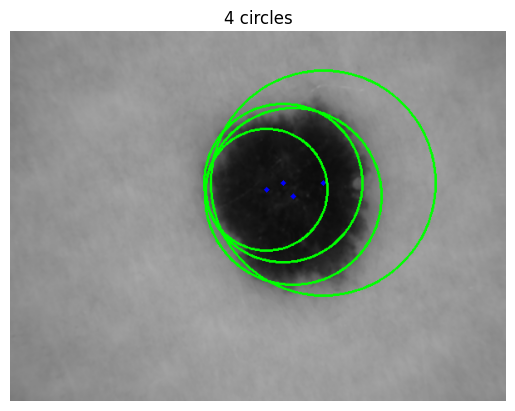

  1%|▏         | 1/68 [00:00<00:26,  2.56it/s]

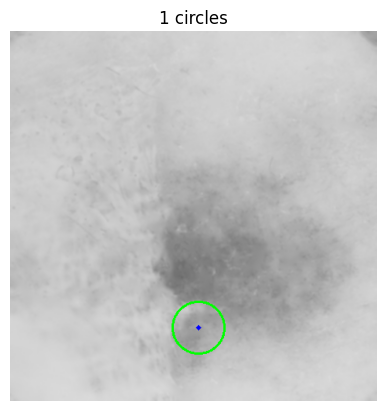

  3%|▎         | 2/68 [00:01<00:49,  1.32it/s]

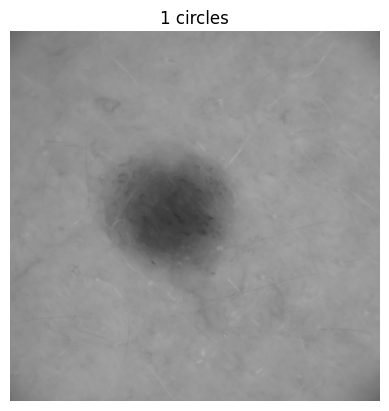

 10%|█         | 7/68 [00:02<00:12,  4.84it/s]

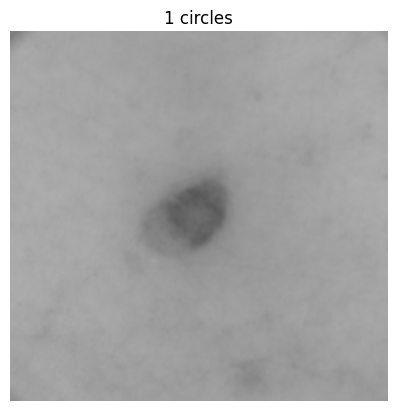

 35%|███▌      | 24/68 [00:03<00:02, 14.99it/s]

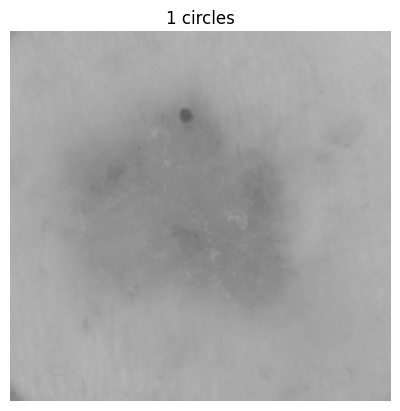

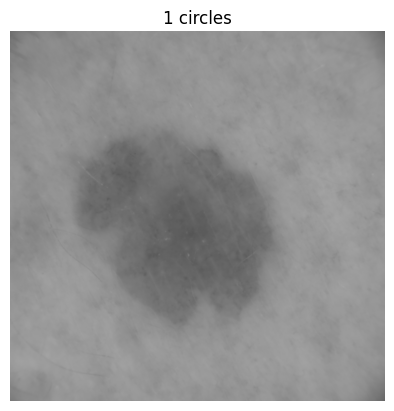

 47%|████▋     | 32/68 [00:04<00:03, 10.30it/s]

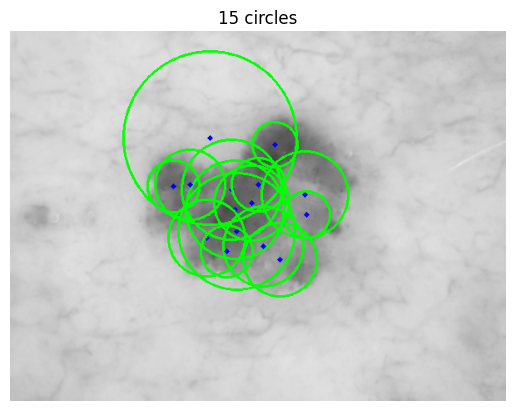

 56%|█████▌    | 38/68 [00:05<00:03,  8.63it/s]

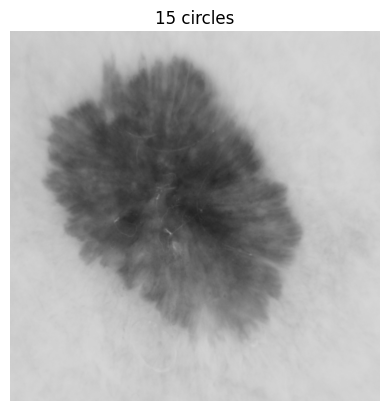

 62%|██████▏   | 42/68 [00:07<00:05,  4.74it/s]

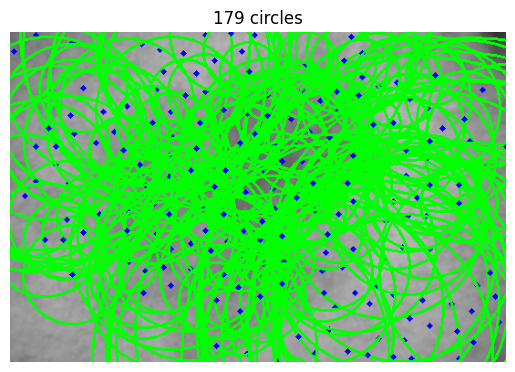

 65%|██████▍   | 44/68 [00:08<00:07,  3.34it/s]

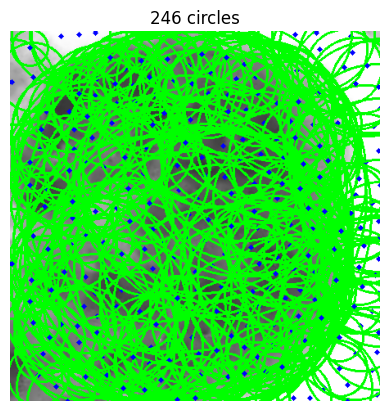

 68%|██████▊   | 46/68 [00:12<00:17,  1.23it/s]

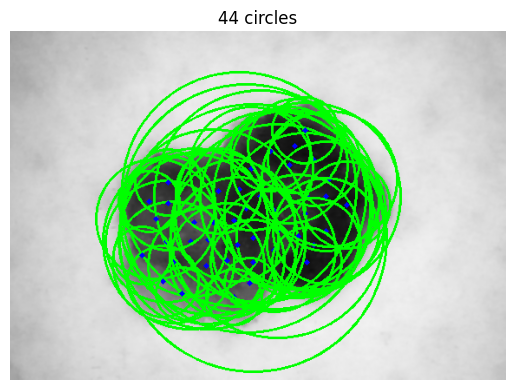

 81%|████████  | 55/68 [00:13<00:02,  4.58it/s]

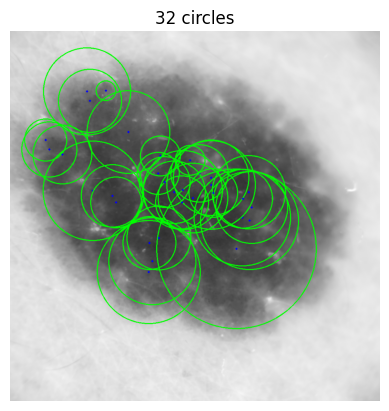

 84%|████████▍ | 57/68 [00:15<00:05,  2.09it/s]

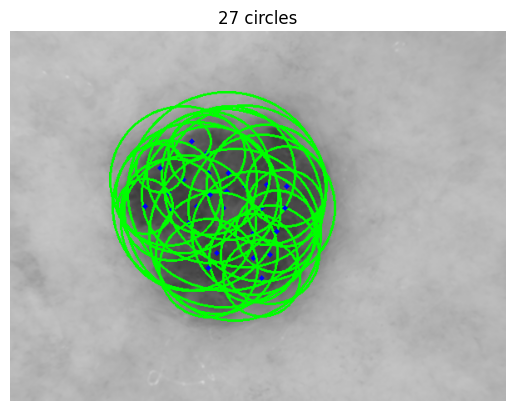

100%|██████████| 68/68 [00:16<00:00,  4.09it/s]


In [37]:
# get features example
all_feat = []
labels = []

radius = 1
n_points = 8 * radius
lbp_feature_vector=[]

for i in tqdm(range(examples.seg_examples_df.shape[0])):

    if examples[i]['problem'] != 'binary':
        continue
    if examples[i]['type'] != 'easy':
        continue

    labels.append(examples[i]['label'])

    image = examples[i]['img']

    image = preproc.preprocess(image) # the img uploaded as numpy array.

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Blur using 3 * 3 kernel.
    gray_blurred = cv2.blur(gray, (3, 3))

    cimg = cv2.cvtColor(gray_blurred,cv2.COLOR_GRAY2BGR)
    circles = cv2.HoughCircles(gray_blurred,cv2.HOUGH_GRADIENT,1,20,
                                param1=52,param2=30,minRadius=0,maxRadius=0)

    # circles = np.uint16(np.around(circles))
    # for i in circles[0,:]:
    #     # draw the outer circle
    #     cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    #     # draw the center of the circle
    #     cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
    # cv2.imshow('detected circles',cimg)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Draw circles that are detected.
    if circles is not None:

        # Convert the circle parameters a, b and r to integers.
        detected_circles = np.uint16(np.around(circles))

        for pt in detected_circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]

            # Draw the circumference of the circle.
            cv2.circle(cimg, (a, b), r, (0, 255, 0), 2)

            # Draw a small circle (of radius 1) to show the center.
            cv2.circle(cimg, (a, b), 1, (0, 0, 255), 3)

    plt.imshow(cimg), plt.axis('off'), plt.title(f'{detected_circles[0].shape[0]} circles'), plt.show()


In [16]:
print(np.argmax(detected_circles[0,:,2]), np.max(detected_circles[0,:,2]))

0 106


In [34]:
image = examples[0]['img']
image = preproc.preprocess(image) # the img uploaded as numpy array.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur using 3 * 3 kernel.
gray_blurred = cv2.blur(gray, (3, 3))

# cimg = cv2.cvtColor(gray_blurred,cv2.COLOR_GRAY2BGR)
for param1 in range(50,70):
    circles = cv2.HoughCircles(gray_blurred,cv2.HOUGH_GRADIENT,1,20,
                                param1=param1,param2=30,minRadius=0,maxRadius=0)
    if circles is not None:
        # Convert the circle parameters a, b and r to integers.
        detected_circles = np.uint16(np.around(circles))
        print(f'param1: {param1}',f'max index: {np.argmax(detected_circles[0,:,2])}/{detected_circles[0].shape[0]}', f'value: {np.max(detected_circles[0,:,2])}')
    else:
        print(f'No circles found for param1: {param1}')

param1: 50 max index: 0/4 value: 106
param1: 51 max index: 0/4 value: 106
param1: 52 max index: 2/4 value: 135
param1: 53 max index: 2/4 value: 135
param1: 54 max index: 0/4 value: 106
param1: 55 max index: 0/4 value: 106
param1: 56 max index: 0/4 value: 102
param1: 57 max index: 0/4 value: 102
param1: 58 max index: 0/2 value: 84
param1: 59 max index: 0/2 value: 84
param1: 60 max index: 0/1 value: 83
param1: 61 max index: 0/1 value: 83
No circles found for param1: 62
No circles found for param1: 63
No circles found for param1: 64
No circles found for param1: 65
No circles found for param1: 66
No circles found for param1: 67
No circles found for param1: 68
No circles found for param1: 69


## Shape Features HU Moments

In [ ]:
preproc = SkinLesionPreprocessing()
examples = SegExamples()

# get features example
all_feat = []
labels = []

for i in tqdm(range(examples.seg_examples_df.shape[0]-67)):

    if examples[i]['problem'] != 'binary':
        continue

    labels.append(examples[i]['label'])

    image = examples[i]['img']

    image = preproc.preprocess(image) # the img uploaded as numpy array.

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,im = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    moments = cv2.moments(im)
    huMoments = cv2.HuMoments(moments)

    for i in range(0,7):
        huMoments[i] = -1* copysign(1.0, huMoments[i]) * log10(abs(huMoments[i])))


    # Draw circles that are detected.
    if circles is not None:

        # Convert the circle parameters a, b and r to integers.
        detected_circles = np.uint16(np.around(circles))

        for pt in detected_circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]

            # Draw the circumference of the circle.
            cv2.circle(cimg, (a, b), r, (0, 255, 0), 2)

            # Draw a small circle (of radius 1) to show the center.
            cv2.circle(cimg, (a, b), 1, (0, 0, 255), 3)

        cv2.imshow("Detected Circle", cimg)
        cv2.waitKey(0)